# STAT8307 Text Mining Group Project

## 6. Title and Headline Sentiment Prediction

### Import libraries

In [2]:
import numpy as np
import pandas as pd
import re
import os

import tensorflow_hub as hub
import tensorflow as tf
import bert

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

### Load data

In [3]:
train_path = "./data/train_new.csv"
train_data = pd.read_csv(train_path)
train_data.dataframeName = 'train_file.csv'

In [4]:
nRow, nCol = train_data.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 55932 rows and 11 columns


### Data Analysis

In [5]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [6]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [7]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


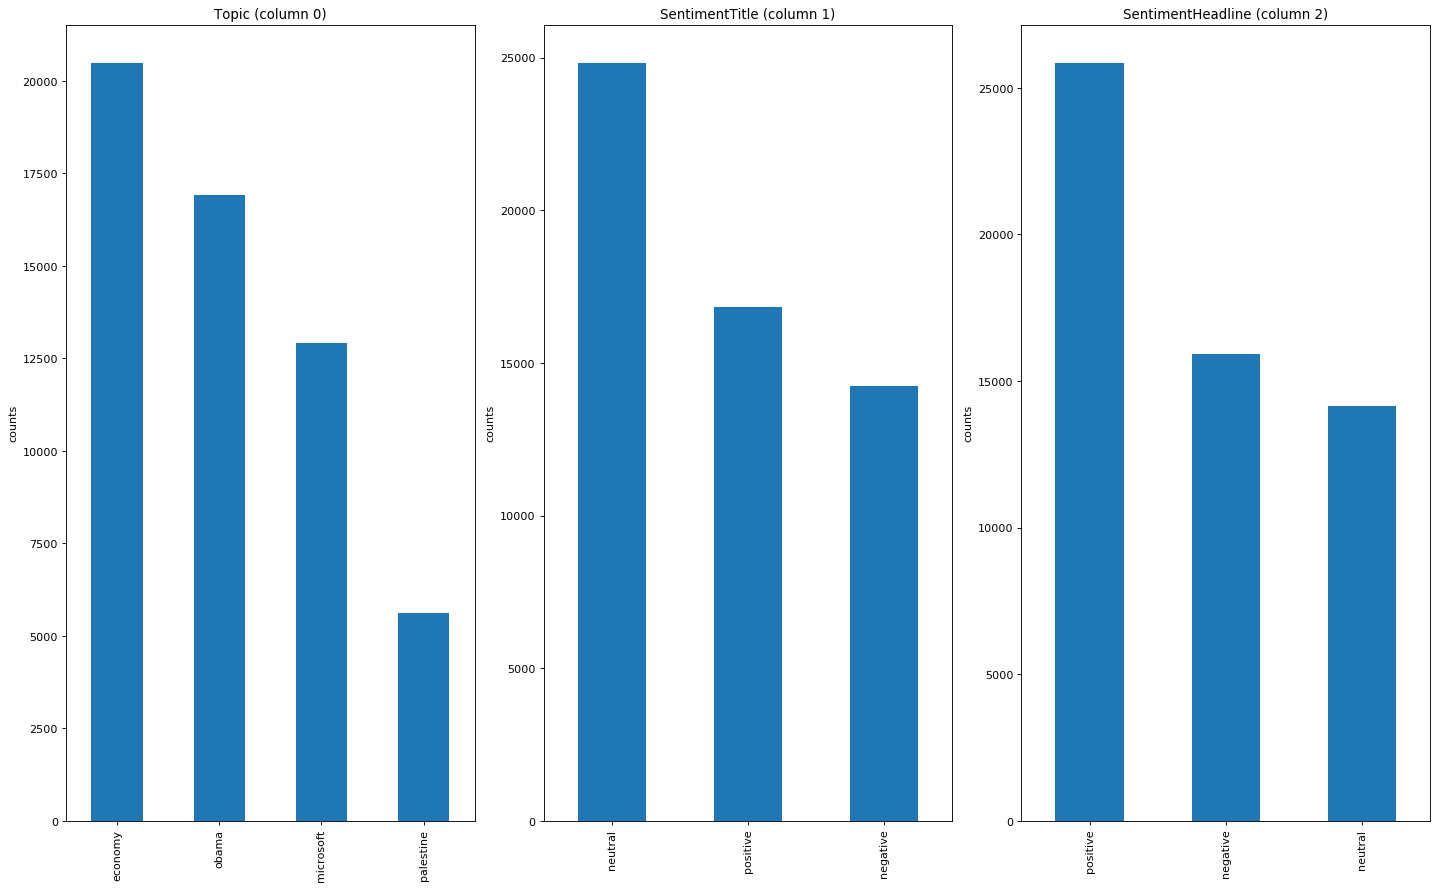

In [8]:
plotPerColumnDistribution(train_data, 10, 5)


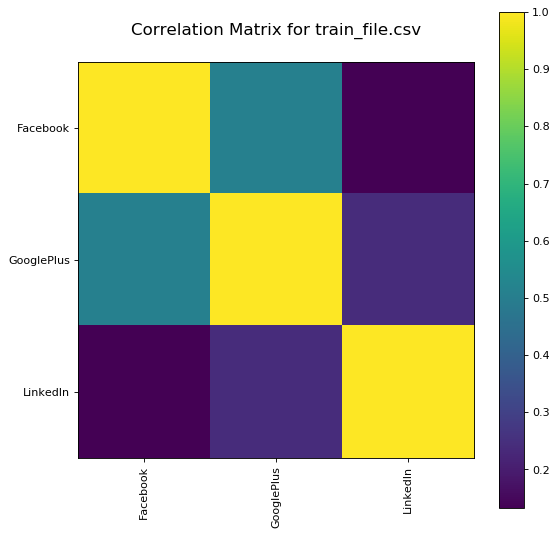

In [9]:
plotCorrelationMatrix(train_data, 8)

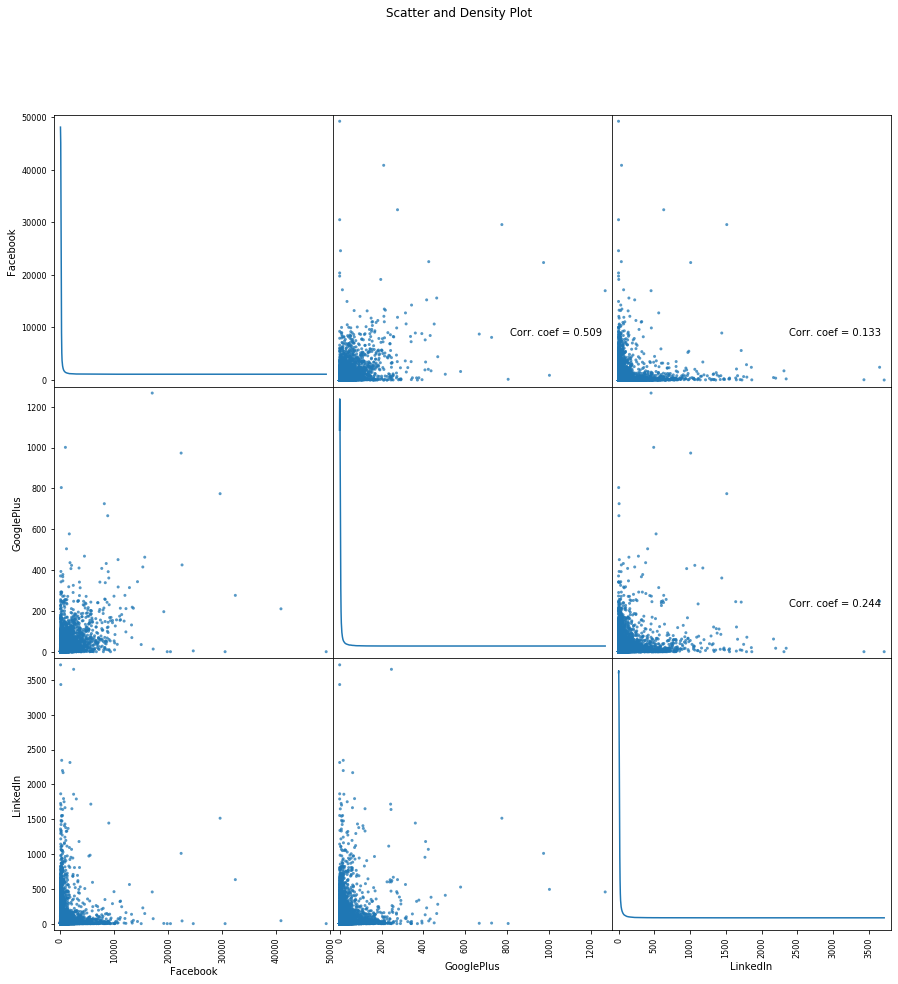

In [10]:
plotScatterMatrix(train_data, 15, 10)

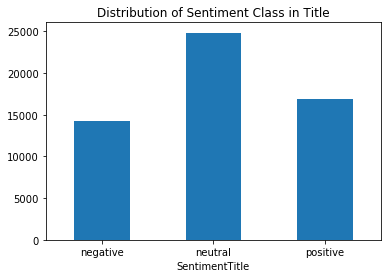

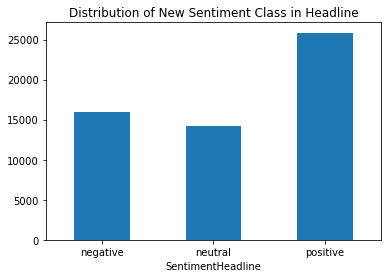

In [11]:
plt.title('Distribution of Sentiment Class in Title')
train_data.groupby(['SentimentTitle']).size().plot.bar(x='lab', y='val', rot=0)
plt.show()
plt.title('Distribution of New Sentiment Class in Headline')
train_data.groupby(['SentimentHeadline']).size().plot.bar(x='lab', y='val', rot=0)
plt.show()

#### Distribution of words

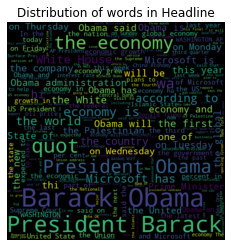

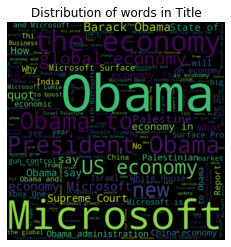

In [12]:
text=train_data['Headline'].str.cat(sep=' ')
# Create the wordcloud object
wordcloud = WordCloud(width=600, height=600, margin=0).generate(text)
# Display the generated image:
plt.title('Distribution of words in Headline')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

text=train_data['Title'].str.cat(sep=' ')
# Create the wordcloud object
wordcloud = WordCloud(width=600, height=600, margin=0).generate(text)
# Display the generated image:
plt.title('Distribution of words in Title')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

### Data Cleansing

The model will have two outputs, sentiment of title and sentiment of headline. In this approach, we assume that the output is positive or negative only. 
If score of sentiment is greater and equal to 0, it is positive. Otherwise, it is negative.

We will filter all null values of data, remove special characters on Title and Headline, drop useless columns and configurate the output labels.

In [13]:
class Cleansing(object):
    @staticmethod
    def clean_null_neutral(df):
        empty = ((df['Title'].isnull()) \
                 | (df['Headline'].isnull()) \
                 | (df['SentimentTitle'].isnull()) \
                 | (df['SentimentHeadline'].isnull()))
        df_result = df[~empty]
        df_result = df_result[~((df_result['SentimentTitle'] == "neutral") | (df_result['SentimentHeadline'] == "neutral"))]
        return df_result

    @staticmethod
    def drop_useless_cols(df):
        df = df.reset_index()
        df = df.loc[:, ['Title', 'Headline', 'SentimentTitle', 'SentimentHeadline']]
        return df

    @staticmethod
    def set_sentiment(df, label):
        def trans_sentiment(row):
            if row == "negative":
                return 0
            else:
                return 1

        df[label] = df[label].apply(trans_sentiment)
        return df

    @staticmethod
    def remove_special_char(df):
        def remove_string_special_characters(s):
            """
            This function removes special characters from within a string.
            parameters:
                s(str): single input string.
            return:
                stripped(str): A string with special characters removed.
            """
            # Replace special character with ' '
            stripped = re.sub('[^\w\s]', '', s)
            stripped = re.sub('_', '', stripped)
            # Change any whitespace to one space
            stripped = re.sub('\s+', ' ', stripped)
            # Remove start and end white spaces
            stripped = stripped.strip()
            return stripped

        df["Title"] = df["Title"].apply(remove_string_special_characters)
        df["Headline"] = df["Headline"].apply(remove_string_special_characters)
        return df

    @staticmethod
    def get_y(df, label):
        df = Cleansing.set_sentiment(df, label)
        #df = Cleansing.set_sentiment(df, 'SentimentHeadline')
        return df[[label]].values

    @staticmethod
    def run_clean(df):
        df_result = Cleansing.clean_null_neutral(df)
        df_result = Cleansing.drop_useless_cols(df_result)
        df_result = Cleansing.remove_special_char(df_result)

        return df_result

In [14]:
train_data = Cleansing.run_clean(train_data)

In [15]:
train_data.head(5)

,Title,Headline,SentimentTitle,SentimentHeadline
0,Intellitec Solutions to Host 13th Annual Sprin...,Over 100 attendees expected to see latest vers...,positive,positive
1,Fire claims more than 100yearold barn in Hanco...,A Hancock County man lost a barn early Monday ...,negative,negative
2,Microsoft Band 2 gains appeal with lower price,The Microsoft Band 2 hit the market in late 20...,positive,positive
3,Swedens economy is on fire but heres why thats...,Swedens economy is on a massive tear but for t...,negative,positive
4,China cuts reserve requirements in bid to boos...,Chinas central bank on Monday cut the proporti...,positive,positive


#### Split data into training and testing datasets

We divide 80% of data to be training data, 20% of data to be testing data

In [16]:
from sklearn.model_selection import train_test_split

train, test_data = train_test_split(train_data, test_size=0.2, random_state=420)

In [17]:
train_y_title = Cleansing.get_y(train, "SentimentTitle")

e:\school\postgrad\dasc7606\env\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
train_y_headline = Cleansing.get_y(train, "SentimentHeadline")

e:\school\postgrad\dasc7606\env\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
train_y = train[["SentimentTitle", "SentimentHeadline"]].values

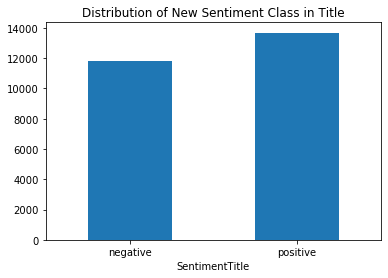

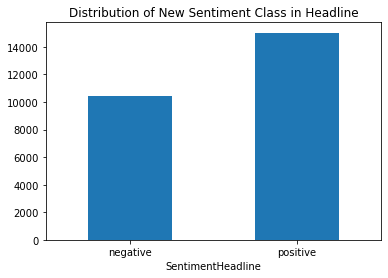

In [20]:
plt.title('Distribution of New Sentiment Class in Title')
train_data.groupby(['SentimentTitle']).size().plot.bar(x='lab', y='val', rot=0)
plt.show()
plt.title('Distribution of New Sentiment Class in Headline')
train_data.groupby(['SentimentHeadline']).size().plot.bar(x='lab', y='val', rot=0)
plt.show()

### Approach 1: One model Two outputs

### BERT model initialization

The model is based on a pretrained model, bert_en_uncased_L-12_H-768_A-12. It creates a tokenizer for data processing later. The tokenizer does lowercase and assign a id on the word token as well.

In [21]:
class BERT(object):
    BERT_MODEL_HUB = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

    def __init__(self):
        self.bert_layer = hub.KerasLayer(self.BERT_MODEL_HUB, trainable=False)
        vocab_file = self.bert_layer.resolved_object.vocab_file.asset_path.numpy()
        do_lower_case = self.bert_layer.resolved_object.do_lower_case.numpy()

        self.tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

    def create_model(self, max_seq_length, num_labels=2, learning_rate=2e-5):

        input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                               name="input_word_ids")
        input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                           name="input_mask")
        segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                            name="segment_ids")

        pooled_output, sequence_output = self.bert_layer([input_word_ids, input_mask, segment_ids])

        x = tf.keras.layers.GlobalMaxPool1D()(sequence_output)
        x = tf.keras.layers.Dense(256, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Dense(256, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        out = tf.keras.layers.Dense(num_labels, activation="sigmoid", name="dense_output")(x)

        model = tf.keras.models.Model(
            inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

        model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
                      metrics=['accuracy', tf.keras.metrics.AUC()])

        return model

We use a deep learning skill, transfer learning to train our new model. The model structure is shown as the following.

##### BERT layers ->  global max pooling -> dense layer of relu -> dropout -> dense layer of relu -> dropout -> dense layer of sigmoid

We use Binary Crossentropy with logits and Adam as the gradient descent optimizer. The learning rate will be 1e-5

### Data processing

Since we need to tranform into bert input format, this will transfer all words into ids, masks and segments which bert needs

We need to figure out what value of max_seq_length is. Therefore, we count the word counts of Title and Headline

In [22]:
train_data['Title_len'] = train_data['Title'].apply(lambda x: len(x.split(" ")))
train_data['Headline_len'] = train_data['Headline'].apply(lambda x: len(x.split(" ")))

In [23]:
train_data['Title_len'].describe()

count    25471.000000
mean         9.041734
std          2.092601
min          2.000000
25%          8.000000
50%          9.000000
75%         10.000000
max         22.000000
Name: Title_len, dtype: float64

In [24]:
train_data['Headline_len'].describe()

count    25471.000000
mean        27.460681
std         12.584677
min          4.000000
25%         21.000000
50%         23.000000
75%         26.000000
max         78.000000
Name: Headline_len, dtype: float64

For the best pracice, we should use a number which is base of 2. In above stats, we choose 32 to be our max_seq_length in order to boost up the training performance. If the max_seq_length is too big, the training time will be so long.

In [25]:
class Processing(object):
    @staticmethod
    def create_single_input(tokenizer, sentence1, sentence2, max_seq_length):
        def get_masks(tokens, max_seq_length):
            return [1] * len(tokens) + [0] * (max_seq_length - len(tokens))

        def get_segments(tokens, max_seq_length):
            """Segments: 0 for the first sequence, 1 for the second"""
            segments = []
            current_segment_id = 0
            for token in tokens:
                segments.append(current_segment_id)
                if token == "[SEP]":
                    current_segment_id = 1
            return segments + [0] * (max_seq_length - len(tokens))

        def get_ids(tokens, tokenizer, max_seq_length):
            """Token ids from Tokenizer vocab"""
            token_ids = tokenizer.convert_tokens_to_ids(tokens, )
            input_ids = token_ids + [0] * (max_seq_length - len(token_ids))
            return input_ids

        stokens = tokenizer.tokenize(sentence1)
        stokens = stokens[:(int(max_seq_length*9/(9+26)) - 2)]

        stokens2 = tokenizer.tokenize(sentence2)
        stokens2 = stokens2[:(int(max_seq_length*26/(9+26)) - 1)]
        stokens = ["[CLS]"] + stokens + ["[SEP]"] + stokens2 + ["[SEP]"]

        ids = get_ids(stokens, tokenizer, max_seq_length)
        masks = get_masks(stokens, max_seq_length)
        segments = get_segments(stokens, max_seq_length)

        return ids, masks, segments

    @staticmethod
    def to_bert_input(tokenizer, data, label1, label2, max_seq_length):

        input_ids, input_masks, input_segments = [], [], []

        for row in data.itertuples():
            ids, masks, segments = Processing.create_single_input(tokenizer, getattr(row, label1), getattr(row, label2), max_seq_length)

            input_ids.append(ids)
            input_masks.append(masks)
            input_segments.append(segments)

        return [np.asarray(input_ids, dtype=np.int32),
                np.asarray(input_masks, dtype=np.int32),
                np.asarray(input_segments, dtype=np.int32)]


#### Create model object

In [26]:
max_length = 32
num_labels = 2
bert = BERT()
model = bert.create_model(max_length, num_labels, learning_rate=1e-5)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 32)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 32)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

#### Tokenize training data

In [27]:
train_example = Processing.to_bert_input(bert.tokenizer, train, "Title", "Headline", max_length)

In [28]:
train_example

[array([[  101,  8112,  2006, ...,   102,     0,     0],
        [  101,  7513, 10629, ...,  3857,   102,     0],
        [  101, 23902,  2013, ...,  2024,   102,     0],
        ...,
        [  101,  2859,  2015, ...,  4355,   102,     0],
        [  101,  7649,  2015, ...,  2144,   102,     0],
        [  101,  2129,  1037, ...,  5008,   102,     0]]),
 array([[1, 1, 1, ..., 1, 0, 0],
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0]]),
 array([[0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0]])]

#### Tokens after tokenizer

In [29]:
stokens_title = train_data['Title'].apply(lambda x : bert.tokenizer.tokenize(x))
stokens_title.head(10)

0    [intel, ##lite, ##c, solutions, to, host, 13th...
1    [fire, claims, more, than, 100, ##year, ##old,...
2    [microsoft, band, 2, gains, appeal, with, lowe...
3    [sweden, ##s, economy, is, on, fire, but, here...
4    [china, cuts, reserve, requirements, in, bid, ...
5    [china, cuts, reserve, requirements, in, bid, ...
6    [obama, encouraging, young, people, to, learn,...
7    [microsoft, un, ##ve, ##ils, a, sl, ##ew, of, ...
8    [china, cuts, reserve, requirements, in, bid, ...
9    [china, ##s, sharing, economy, generates, usd,...
Name: Title, dtype: object

In [30]:
stokens_headline = train_data['Headline'].apply(lambda x : bert.tokenizer.tokenize(x))
stokens_headline.head(10)

0    [over, 100, attendees, expected, to, see, late...
1    [a, hancock, county, man, lost, a, barn, early...
2    [the, microsoft, band, 2, hit, the, market, in...
3    [sweden, ##s, economy, is, on, a, massive, tea...
4    [china, ##s, central, bank, on, monday, cut, t...
5    [china, ##s, central, bank, on, monday, cut, t...
6    [president, barack, obama, is, launching, a, v...
7    [microsoft, unleashed, a, number, of, new, sec...
8    [beijing, china, ##s, central, bank, on, monda...
9    [men, ##af, ##n, sharing, economy, platforms, ...
Name: Headline, dtype: object

### Training

We train the model in 20 epochs. In the end, it will save the weights.

In [31]:
total_epochs = 20
save_model_path = "./trained_model/approach1.h5"
checkpoint = os.path.join("./trained_model", "bert_faq.ckpt")

In [ ]:
model.fit(train_example, train_y, epochs=total_epochs, batch_size=32, validation_split=0.2, shuffle=True,
              callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=True, verbose=1),
                         tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)])
model.save_weights(save_model_path)

Since running time is so long, we won't run the fit code here.

loss: 0.4863 - accuracy: 0.7665 - auc: 0.8423 - val_loss: 0.5170 - val_accuracy: 0.7414 - val_auc: 0.8197

### Predict

#### Prepare testing data

In [32]:
test_example = Processing.to_bert_input(bert.tokenizer, test_data, "Title", "Headline", max_length)
test_y =  test_data[["SentimentTitle", "SentimentHeadline"]].values
test_y_title = Cleansing.get_y(test_data, "SentimentTitle")
test_y_headline = Cleansing.get_y(test_data, "SentimentHeadline")

e:\school\postgrad\dasc7606\env\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
test_example

[array([[  101,  2034,  3191, ...,  2002,   102,     0],
        [  101,  7404,  4400, ..., 10574,   102,     0],
        [  101,  6739,  5328, ...,  2000,   102,     0],
        ...,
        [  101,  2160,  2175, ..., 19317,   102,     0],
        [  101,  2129,  2028, ...,  4430,   102,     0],
        [  101,  2995,  2110, ...,  9701,   102,     0]]),
 array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0]]),
 array([[0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0]])]

In [34]:
test_y

array([['positive', 'negative'],
       ['negative', 'negative'],
       ['positive', 'positive'],
       ...,
       ['positive', 'positive'],
       ['positive', 'negative'],
       ['positive', 'positive']], dtype=object)

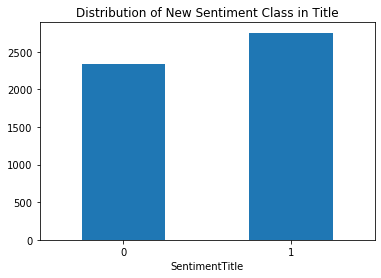

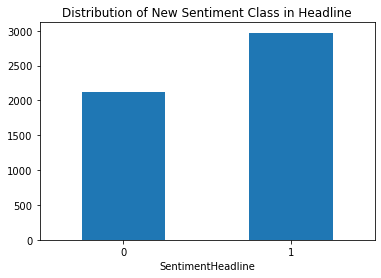

In [35]:
plt.title('Distribution of New Sentiment Class in Title')
test_data.groupby(['SentimentTitle']).size().plot.bar(x='lab', y='val', rot=0)
plt.show()
plt.title('Distribution of New Sentiment Class in Headline')
test_data.groupby(['SentimentHeadline']).size().plot.bar(x='lab', y='val', rot=0)
plt.show()

#### Load the weights of model

In [36]:
model.load_weights(save_model_path)

#### Evaluate the model

In [ ]:
loss,acc = model.evaluate(test_example, test_y, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

In [ ]:
predictions = model.predict(test_example)

In [ ]:
predictions

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
labels = ["Sentiment of Title", "Sentiment of Headline"]
for i in range(num_labels):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(labels[i])
    plt.legend(loc="lower right")
    plt.show()

### Approach 2: Two models One output

#### Create model object

In [ ]:
max_length = 32
num_labels = 1
bert = BERT()
model_title = bert.create_model(max_length, num_labels, learning_rate=1e-5)
model_title.summary()

In [ ]:
bert = BERT()
model_headline = bert.create_model(max_length, num_labels, learning_rate=1e-5)
model_headline.summary()

### Training

In [ ]:
total_epochs = 20
save_model_path_title = "./trained_model/approach2_title.h5"
checkpoint = os.path.join("./trained_model", "bert_faq.ckpt")

In [ ]:
model_title.fit(train_example, train_y_title, epochs=total_epochs, batch_size=32, validation_split=0.2, shuffle=True,
              callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=True, verbose=1),
                         tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)])
model_title.save_weights(save_model_path_title)

Since running time is so long, we won't run the fit code here.

loss: 0.4984 - accuracy: 0.7544 - auc: 0.8354 - val_loss: 0.5568 - val_accuracy: 0.7186 - val_auc: 0.8094

In [ ]:
total_epochs = 20
save_model_path_headline = "./trained_model/approach2_headline.h5"
checkpoint = os.path.join("./trained_model", "bert_faq.ckpt")

In [ ]:
model_headline.fit(train_example, train_y_headline, epochs=total_epochs, batch_size=32, validation_split=0.2, shuffle=True,
              callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=True, verbose=1),
                         tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)])
model_headline.save_weights(save_model_path_headline)

In [ ]:
Since running time is so long, we won't run the fit code here.

loss: 0.4602 - accuracy: 0.7858 - auc: 0.8579 - val_loss: 0.4983 - val_accuracy: 0.7490 - val_auc: 0.8339

#### Load the weights of model

In [ ]:
model_title.load_weights(save_model_path_title)

In [ ]:
model_headline.load_weights(save_model_path_headline)

#### Evaluate the model

Title one

In [ ]:
loss,acc = model_title.evaluate(test_example, test_y_title, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

In [ ]:
predictions = model_title.predict(test_example)

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve(test_y_title[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


In [ ]:
labels = ["Sentiment of Title"]
for i in range(num_labels):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(labels[i])
    plt.legend(loc="lower right")
    plt.show()

Headline one

In [ ]:
loss,acc = model_headline.evaluate(test_example, test_y_headline, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

In [ ]:
predictions = model_headline.predict(test_example)

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve(test_y_headline[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

In [ ]:
labels = ["Sentiment of Headline"]
for i in range(num_labels):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(labels[i])
    plt.legend(loc="lower right")
    plt.show()